<a href="https://colab.research.google.com/github/Kulabus/Kulabus/blob/main/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BB%D0%B8%D1%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Распознавание лиц и дорисовка очков

На загруженных фотографиях знаменитостей распознаётся лицо и глаза с использованием классификаторов OpenCV на основе каскада Хаара.

Обнаруженный квадрат лица "блюрим", вокруг него рисуем овал. На глаза дорисовываем загруженное изображение очков.

<h3>Распознавание лиц с помощью библиотеки OpenCV

In [ ]:
import cv2

# Функция для размытия изображения
def blur_face(img):
  (h, w) = img.shape[:2]
  dW = int(w / 3.0)
  dH = int(h / 3.0)
  if dW % 2 == 0:
      dW -= 1
  if dH % 2 == 0:
      dH -= 1
  return cv2.GaussianBlur(img, (dW, dH), 0)

### Дэниел Редклифф

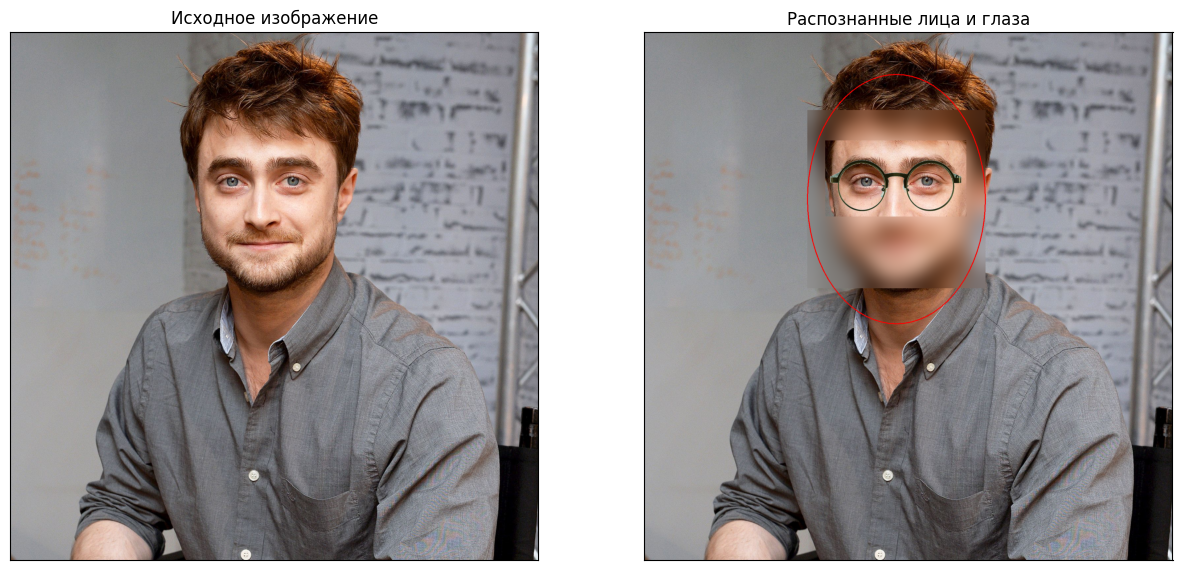

In [ ]:
import cv2
import gdown
import requests
from matplotlib import pyplot
# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline


gdown.download('https://storage.yandexcloud.net/tg-bot-buket/Radcliffe.jpg', None, quiet=True)

url = 'https://avatars.mds.yandex.net/i?id=de36d156eb23a4c6582024fb760f8df3_l-4077252-images-thumbs&n=13'
response = requests.get(url)
with open('Glasses.png', 'wb') as file:
    file.write(response.content)

# Загрузка изображения
img = cv2.imread('./Radcliffe.jpg')
img2 = img.copy()

# Загрузим очки
glasses_mask = cv2.imread('./Glasses.png')[120:600, 7:]
h_mask, w_mask = glasses_mask.shape[:2]

# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")

# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")

# выполнение распознавания лиц
bboxes = classifier_face.detectMultiScale(img, minNeighbors=2, minSize=(300, 300))

# Обработка каждого обнаруженного лица
for box in bboxes:
    # формирование координат
    x, y, width, height = box

    face = img2[y:y + height, x:x + width] # найденная область с лицом

    # выполнение распознавания глаз
    eyes = classifier_eye.detectMultiScale(face)

    if len(eyes) > 0:
        # Определяем границы области глаз по оси x
        if eyes[0][0] < eyes[1][0]:
            ex1 = eyes[0][0] - 50
            ex2 = eyes[1][0] + eyes[1][2] + 50
        else:
            ex1 = eyes[1][0] - 50
            ex2 = eyes[0][0] + eyes[0][2] + 50

        eh = h_mask * (ex2 - ex1) / w_mask

        # Определяем границы области глаз по оси y
        if eyes[0][1] < eyes[1][1]:
            ey1 = eyes[0][1]
            ey2 = eyes[1][1] + eyes[1][3]
            ey1, ey2 = int(ey1 + ((ey2 - ey1) / 2) - eh / 2), int(ey1 + ((ey2 - ey1) / 2) + eh / 2)
        else:
            ey1 = eyes[1][1]
            ey2 = eyes[0][1] + eyes[0][3]
            ey1, ey2 = int(ey1 + ((ey2 - ey1) / 2) - eh / 2), int(ey1 + ((ey2 - ey1) / 2) + eh / 2)

        # область глаз
        eyes_area = face[ey1:ey2, ex1:ex2]

        # Маштабируем очки до размера глаз
        glasses_mask_small = cv2.resize(glasses_mask, (ex2 - ex1, ey2 - ey1), fx=(ex2 - ex1)/w_mask, fy=(ex2 - ex1)/w_mask, interpolation=cv2.INTER_AREA)

        # Сделаем наши очки черно-белыми и применим инвариантный бинарный порог, как это делали с номерами
        gray_mask = cv2.cvtColor(glasses_mask_small, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(gray_mask, 215, 255, cv2.THRESH_BINARY_INV)

        # Инвертируем маску
        mask_inv = cv2.bitwise_not(mask)

        # побитовое AND для двух изображений, результирующая - пиксели присутствующие на обоих изображениях
        masked_eyes = cv2.bitwise_and(glasses_mask_small, glasses_mask_small, mask=mask)
        masked_face = cv2.bitwise_and(eyes_area, eyes_area, mask=mask_inv)

        # Блюрим лицо
        img2[y:y + height, x:x + width] = blur_face(img2[y:y + height, x:x + width])

        # Объединяем глаза и очки
        face[ey1:ey2, ex1:ex2] = cv2.add(masked_eyes, masked_face)

    # определяем центр овала
    center = (int(x + 0.5*width), int(y + 0.5*height))
    axesLength = (int(0.5*width), int(0.7*height))
    angle = 0
    startAngle = 0
    endAngle = 360
    color = (0, 0, 255)
    thickness = 2

    # Рисуем овал вокруг лица
    cv2.ellipse(img2, center, axesLength, angle, startAngle, endAngle, color, thickness)


fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Лицо, овал, глаза, очки, блюр')

pyplot.show()


### Дэниел Крейг

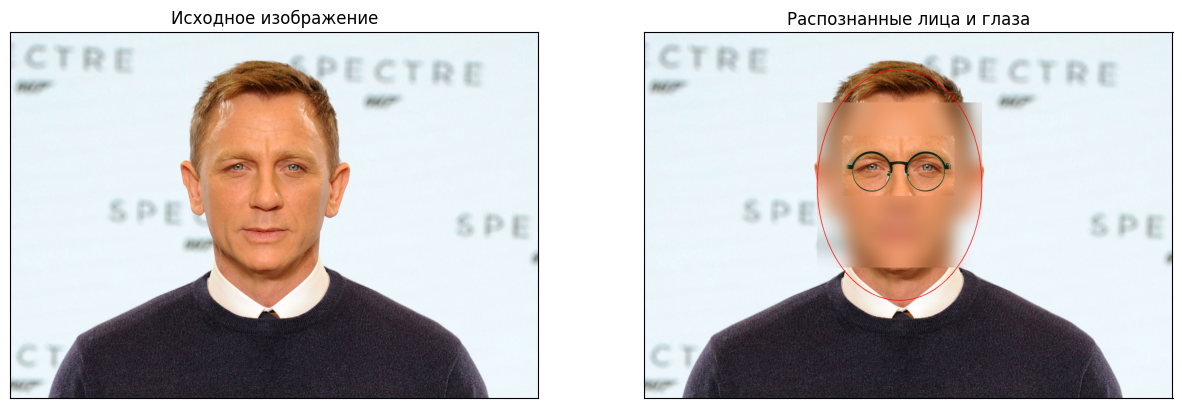

In [ ]:
import cv2
import requests
from matplotlib import pyplot
# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline

url = 'https://avatars.mds.yandex.net/i?id=de36d156eb23a4c6582024fb760f8df3_l-4077252-images-thumbs&n=13'
response = requests.get(url)
with open('Glasses.png', 'wb') as file:
    file.write(response.content)

url = 'https://biyografili.com/img/up/biyografi-daniel-craig.jpeg'
response = requests.get(url)
with open('Kraig.jpg', 'wb') as file:
    file.write(response.content)

# Загрузка изображения
img = cv2.imread('./Kraig.jpg')
img2 = img.copy()

# Загрузим очки
glasses_mask = cv2.imread('./Glasses.png')[120:600, 7:]
h_mask, w_mask = glasses_mask.shape[:2]

# загрузка каскада Хаара для поиска лиц
classifier_face = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_frontalface_default.xml")


# загрузка каскада Хаара для поиска глаз
classifier_eye = cv2.CascadeClassifier(cv2.data.haarcascades+ "haarcascade_eye.xml")

# выполнение распознавания лиц
bboxes = classifier_face.detectMultiScale(img, minNeighbors=2, minSize=(300, 300))

# Обработка каждого обнаруженного лица
for box in bboxes:
    # формирование координат
    x, y, width, height = box

    face = img2[y:y + height, x:x + width] # найденная область с лицом

    # выполнение распознавания глаз
    eyes = classifier_eye.detectMultiScale(face)

    if len(eyes) > 0:
        # Определяем границы области глаз по оси x
        if eyes[0][0] < eyes[1][0]:
            ex1 = eyes[0][0] - 50
            ex2 = eyes[1][0] + eyes[1][2] + 50
        else:
            ex1 = eyes[1][0] - 50
            ex2 = eyes[0][0] + eyes[0][2] + 50

        # Посчитаем высоту области глаз
        eh = h_mask * (ex2 - ex1) / w_mask

        # Определяем границы области глаз по оси y
        if eyes[0][1] < eyes[1][1]:
            ey1 = eyes[0][1]
            ey2 = eyes[1][1] + eyes[1][3]
            ey1, ey2 = int(ey1 + ((ey2 - ey1) / 2) - eh / 2), int(ey1 + ((ey2 - ey1) / 2) + eh / 2)
        else:
            ey1 = eyes[1][1]
            ey2 = eyes[0][1] + eyes[0][3]
            ey1, ey2 = int(ey1 + ((ey2 - ey1) / 2) - eh / 2), int(ey1 + ((ey2 - ey1) / 2) + eh / 2)

        # Область глаз
        eyes_area = face[ey1:ey2, ex1:ex2]

        # Маштабируем очки до размера глаз
        glasses_mask_small = cv2.resize(glasses_mask, (ex2 - ex1, ey2 - ey1), fx=(ex2 - ex1)/w_mask, fy=(ex2 - ex1)/w_mask, interpolation=cv2.INTER_AREA)

        # Сделаем наши очки черно-белыми и применим инвариантный бинарный порог
        gray_mask = cv2.cvtColor(glasses_mask_small, cv2.COLOR_BGR2GRAY)
        ret, mask = cv2.threshold(gray_mask, 215, 255, cv2.THRESH_BINARY_INV)

        # Инвертируем маску
        mask_inv = cv2.bitwise_not(mask)

        # побитовое AND для двух изображений, результирующая - пиксели присутствующие на обоих изображениях
        masked_eyes = cv2.bitwise_and(glasses_mask_small, glasses_mask_small, mask=mask)
        masked_face = cv2.bitwise_and(eyes_area, eyes_area, mask=mask_inv)

        # Блюрим лицо
        img2[y:y + height, x:x + width] = blur_face(img2[y:y + height, x:x + width])

        # Объединяем глаза и очки
        face[ey1:ey2, ex1:ex2] = cv2.add(masked_eyes, masked_face)

    # определяем центр овала
    center = (int(x + 0.5*width), int(y + 0.5*height))
    axesLength = (int(0.5*width), int(0.7*height))
    angle = 0
    startAngle = 0
    endAngle = 360
    color = (0, 0, 255)
    thickness = 2

    # Рисуем овал вокруг лица
    cv2.ellipse(img2, center, axesLength, angle, startAngle, endAngle, color, thickness)


fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(15, 8))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')

ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])
ax2.set_title('Лицо, овал, глаза, очки, блюр')

pyplot.show()


(390, 894)


Text(0.5, 1.0, 'Исходное изображение')

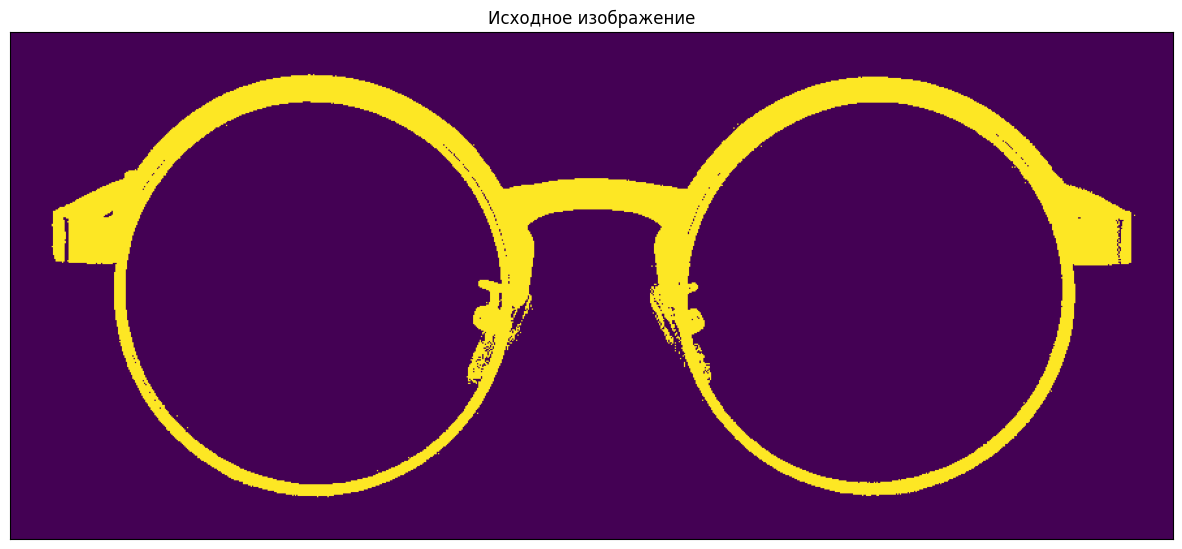

In [ ]:
# Корректцировка изображения очков

import cv2
import gdown
from matplotlib import pyplot
# Команда обеспечивает вывод графиков в Google Colaboratory
%matplotlib inline

import requests
url = 'https://avatars.mds.yandex.net/i?id=de36d156eb23a4c6582024fb760f8df3_l-4077252-images-thumbs&n=13'
response = requests.get(url)
with open('Glasses.png', 'wb') as file:
    file.write(response.content)

# Загрузка изображения
image = cv2.imread('./Glasses.png')[210:600, 6:]

print(image.shape[:2])

gray_mask = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, mask = cv2.threshold(gray_mask, 215, 255, cv2.THRESH_BINARY_INV)

fig, ax1 = pyplot.subplots(1, 1, figsize=(15, 8))
ax1.imshow(mask)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax1.set_title('Исходное изображение')
